# The Data

When fetching the ticker ES=F from Yahoo Finance, we obtain these columns:

Price	       Datetime	             Close	 High	  Low	 Open	Volume
0	    2024-02-22 17:00:00-06:00	5099.00	5100.50	5094.00	5094.25	0
1	    2024-02-22 18:00:00-06:00	5095.75	5099.25	5092.25	5098.75	9420
2	    2024-02-22 19:00:00-06:00	5099.50	5101.75	5095.00	5095.75	7390
3	    2024-02-22 20:00:00-06:00	5100.25	5102.50	5099.50	5099.75	4922
4	    2024-02-22 21:00:00-06:00	5101.25	5102.00	5099.75	5100.50	4426

The date time format corresponds to:

- YYYY-MM-DD → The date (Year-Month-Day)
- HH:MM:SS → The time in 24-hour format (Hour:Minute:Second)
- 06:00 → The timezone offset from UTC, which in this case is UTC-6 (Central Time, since you set tz="America/Chicago")



# Forecasting Period

There are less data points for the first two months and the last month of the year.

| Q1        | Q1        | Q1     | Q2     | Q2  | Q2  | Q3  | Q3     | Q3        | Q4     | Q4      | Q4          |
|:-----------|:-----------|:--------|:--------|:----|:----|:----|:-------|:---------|:--------|:--------|:-----------|
| January    | February    | March   | April   | May | June | July | August | September | October | November | December  |
|             |              | 2023   | 2023   | 2023 | 2023 | 2023 | 2023     | 2023      | 2023    | 2023     | 2023       |
| 2024       | 2024         | 2024    | 2024    | 2024 | 2024 | 2024 | 2024     | 2024      | 2024    | 2024     | 2024 (partial) |

# Heatmap Analysis

### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

### Constants

This section stores constants for all sections that generate heatmap.
There are values and labels for year, quarter, month, day, hour (+ day and night), horizon and models

In [2]:
years = [2023, 2024]

days = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
}
day_labels = [v for k,v in days.items()]

weeks = {i: i+1 for i in range(13)}
weeks_label = [v for k,v in weeks.items()]

hours = {
    0: "12AM",  1: "1AM",  2: "2AM",  3: "3AM",  4: "4AM",  5: "5AM",
    6: "6AM",  7: "7AM",  8: "8AM",  9: "9AM",  10: "10AM", 11: "11AM",
    12: "12PM", 13: "1PM", 14: "2PM", 15: "3PM", 16: "4PM", 17: "5PM",
    18: "6PM", 19: "7PM", 20: "8PM", 21: "9PM", 22: "10PM", 23: "11PM"
}

hour_labels = ['12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v']

day_hours = {0: "8AM",  1: "9AM",  2: "10AM", 3: "11AM", 4: "12PM", 5: "1PM", 6: "2PM", 7: "3PM", 8: "4PM"}
day_hours_labels = ['8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM']

night_hours = {0: "5PM", 1: "6PM", 2: "7PM", 3: "8PM", 4: "9PM", 5: "10PM", 6: "11PM", 7: "12AM", 8: "1AM",  9: "2AM",  10: "3AM",  11: "4AM",  12: "5AM", 13: "6AM",  14: "7AM"}
night_hours_labels = ['5PM-v', '6PM-v', '7PM-v', '8PM-v', '9PM-v', '10PM-v', '11PM-v', '12AM', '1AM', '2AM', '3AM', '4AM', '5AM', '6AM', '7AM']

months = {i: i+1 for i in range(12)}
months_label = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

quarters = {i: i+1 for i in range(4)}
quarters_label = ['Q1', 'Q2', 'Q3', 'Q4']

horizons = [0, 1, 2]
horizons_label = [1, 2, 3]

future = "es"
models = {0: "moirai", 1: "chronos", 2: "time_moe"}
models_label = ["Moirai", "Chronos", "Time-MoE"]

### Toy function to understand how the precision is computed

This code is used to explain how do we compute the signs and the predictions. It is not used in practice, it is for demonstration only.
Also, it doesn't use the TP, FP, TN, FN columns that were added in the dataframes.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np

def precision_per_day(file_path, 
              target="Close",
              horizon=3, 
              date=None):

    df = pd.read_csv(file_path, parse_dates=True, index_col=0)
    df.dropna(inplace=True)  # remove NaN values
    # Force index to be in datetime format
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, utc=True)  # Convert to datetime, force UTC
    # Convert from UTC to local time (assuming original data is in GMT-6)
    df.index = df.index.tz_convert("America/Chicago")  # Convert to Central Time
            
    df['Row_Position'] = range(len(df))  # Add original row position column

    df_date = df.loc[date]  # Filter rows by date
    
    df_date_index_start = df_date.iloc[0]["Row_Position"]
    df_date_index_end = df_date.iloc[-1]["Row_Position"]

    # We take extra values (as many as there are horizons) to be able to predict the sign
    # Correctly extract future timestamps from df.index
    df_ground_truth_start_time = df.index[df_date_index_start + 1]
    df_ground_truth_end_time = df.index[df_date_index_end + horizon]  # Prevent out-of-bounds

    df_ground_truth = df.loc[df_ground_truth_start_time : df_ground_truth_end_time]

    TP = [0 for _ in range(horizon)]
    TN = [0 for _ in range(horizon)]
    FP = [0 for _ in range(horizon)]
    FN = [0 for _ in range(horizon)]


    #print("\n ---------- \nDate: ", date)
    #print("Ground truth start time: ", df_ground_truth_start_time)
    #print("Ground truth end time: ", df_ground_truth_end_time)

    # for each day
    for index, row in df_date.iterrows():
        #print("\n")
        #print("Hour: ", index)
        row_index = row["Row_Position"]
        base = row[target]
        results_list = ast.literal_eval(row["Result"])
        
        for horizon_index in range(1, horizon+1):
            #print("Horizon n°", horizon_index)
            # locate the row + horizon_index 
            future_time = df.index[row_index + horizon_index]
            y = df_ground_truth.loc[future_time, target]
            prediction_result = results_list[horizon_index-1]
            #print("Base: ", base, "Real: ", y, "Prediction: ", prediction_result)
            sign_real_difference = np.sign(y - base)
            sign_prediction_difference = np.sign(prediction_result - base)
            #print("Real sign difference: ", sign_real_difference)
            #print("Prediction sign difference: ", sign_prediction_difference)
            
            if sign_prediction_difference == 1 and sign_real_difference == 1:
                TP[horizon_index-1] += 1
            elif sign_prediction_difference == -1 and sign_real_difference == -1:
                TN[horizon_index-1] += 1
            elif sign_prediction_difference == 1 and sign_real_difference == -1:
                FP[horizon_index-1] += 1
            elif sign_prediction_difference == -1 and sign_real_difference == 1:
                FN[horizon_index-1] += 1
            else:
                print("Error with signs. See the following values:")
                print(f"Real: {sign_real_difference}, Prediction: {sign_prediction_difference}")
                print(f"Real: {y}, Prediction: {prediction_result}")
    return TP, TN, FN, FP

### Helper function to compute the TP, FP, TN, FN for every row of one dataframe

In [ ]:
def helper_metric(filepath: str):

    df = pd.read_csv(f"{filepath}.csv", parse_dates=True, index_col=0)

    # TP: True Positive, TN: True Negative, FP: False Positive, FN: False Negative
    df["TP"] = 0
    df["TN"] = 0
    df["FP"] = 0
    df["FN"] = 0

    # We take the first 384 rows as context. We start predicting from the 385th row
    first_predicted_row = 383
    last_predicted_row = len(df) - 12
    
    for index, row in df[first_predicted_row:last_predicted_row].iterrows():
        base_price = row['Close']
        future_predictions = ast.literal_eval(row["Result"])
        future_prices = df.loc[index:].iloc[1:13]["Close"].tolist() # get the next 12 values corresponding to the next 12 horizons
        real_difference_signs = [np.sign(price - base_price) for price in future_prices]
        predicted_difference_signs = [np.sign(prediction - base_price) for prediction in future_predictions]

        TP = [0 for _ in range(12)]
        TN = [0 for _ in range(12)]
        FP = [0 for _ in range(12)]
        FN = [0 for _ in range(12)]

        # Compute the TP, TN, FP, FN for each horizon
        for horizon_index, (real_difference_sign, predicted_difference_sign) in enumerate(zip(real_difference_signs, predicted_difference_signs)):
            if real_difference_sign == predicted_difference_sign and real_difference_sign == 1:
                TP[horizon_index] += 1
            elif real_difference_sign == predicted_difference_sign and real_difference_sign == -1:
                TN[horizon_index] += 1
            elif real_difference_sign != predicted_difference_sign and real_difference_sign == 1:
                FN[horizon_index] += 1
            elif real_difference_sign != predicted_difference_sign and real_difference_sign == -1:
                FP[horizon_index] += 1

        # fill the column for TP, TN, FP, FN for the current row
        df.at[index, "TP"] = str(TP)
        df.at[index, "TN"] = str(TN)
        df.at[index, "FP"] = str(FP)
        df.at[index, "FN"] = str(FN)
        
    df.to_csv(f"{filepath}_new_version.csv", index=True)

# Compute the TP, TN, FP, FN colulns for each model's dataframe
# for model_index, model_name in models.items():
#     helper_metric(filepath=f"../future_data/es_future_final_{model_name}")

### Helper functions to plot heatmaps

This helper function creates an extended heatmap with averages for rows and columns.

In [3]:
def create_extended_heatmap_data(base_data, tp_data, fp_data):
    """
    Return an extended array that appends:
      - A new last column with each row's ratio-of-sums
      - A new last row with each column's ratio-of-sums
      - The bottom-right cell with the ratio-of-total-sums
    base_data: the cell-level precision
    tp_data, fp_data: the sums of TPs and FPs for each cell
    """
    n_rows, n_cols = base_data.shape

    # Prepare the extended array
    extended = np.zeros((n_rows + 1, n_cols + 1), dtype=float)

    # Fill in the main area
    extended[:n_rows, :n_cols] = base_data

    # Compute row-average via ratio of sums
    for r in range(n_rows):
        row_tp = np.sum(tp_data[r, :])
        row_fp = np.sum(fp_data[r, :])
        if row_tp + row_fp > 0:
            extended[r, -1] = row_tp / (row_tp + row_fp)
        else:
            extended[r, -1] = 0.0

    # Compute column-average via ratio of sums
    for c in range(n_cols):
        col_tp = np.sum(tp_data[:, c])
        col_fp = np.sum(fp_data[:, c])
        if col_tp + col_fp > 0:
            extended[-1, c] = col_tp / (col_tp + col_fp)
        else:
            extended[-1, c] = 0.0

    # Bottom-right cell: ratio of total TPs / total (TPs+FPs)
    total_tp = np.sum(tp_data)
    total_fp = np.sum(fp_data)
    if total_tp + total_fp > 0:
        extended[-1, -1] = total_tp / (total_tp + total_fp)
    else:
        extended[-1, -1] = 0.0

    return extended

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_extended_heatmap(extended_data, x_labels, y_labels, xlabel, ylabel, title,
                          cmap=plt.cm.RdYlGn, norm_range=(0.65, 0.85), figsize=(14, 10)):
    """
    Plot the heatmap given the extended data and labels.
    The x_labels and y_labels should include the label for the extra (average) column/row.
    """

    # Append 'Avg' labels for extra column and row
    x_labels = x_labels + ['Avg']
    y_labels = y_labels + ['Avg']

    plt.figure(figsize=figsize)
    norm = plt.Normalize(*norm_range)
    heatmap = plt.imshow(extended_data, cmap=cmap, norm=norm, aspect='auto')

    # Colorbar with label
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Mean Precision', fontsize=12)

    # Adjust tick sizes
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, fontsize=12, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, fontsize=12)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)

    # Annotate each cell with its numeric value
    for i in range(extended_data.shape[0]):
        for j in range(extended_data.shape[1]):
            value = extended_data[i, j]
            plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black', fontsize=14)

    plt.tight_layout()
    output_path = f"analysis/heatmaps/temporary_heatmaps/{title}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    # Overwrite with a compressed version
    Image.open(output_path).save(output_path, format="PNG", optimize=True, compress_level=9)

    plt.show()


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_extended_heatmap_volume(extended_data, x_labels, y_labels, xlabel, ylabel, title,
                          cmap=plt.cm.viridis, figsize=(14, 10)):
    """
    Plots a heatmap from the provided extended data, displaying row and column averages. 
    The heatmap is dynamically normalized to improve visual clarity and includes annotated 
    cell values.

    Parameters:
    -----------
    extended_data : array-like
        The data matrix that includes original values plus appended row and column averages.
    x_labels : list
        Labels for the x-axis corresponding to the columns of the original data.
    y_labels : list
        Labels for the y-axis corresponding to the rows of the original data.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    title : str
        Title of the heatmap.
    cmap : matplotlib colormap, optional
        Colormap for the heatmap (default is `plt.cm.viridis`).
    figsize : tuple, optional
        Figure size for the heatmap plot (default is `(14, 10)`).

    Returns:
    --------
    None
        The function saves the heatmap as a compressed PNG file and displays the plot."
    """

    # Append 'Avg' labels for extra column and row
    x_labels = x_labels + ['Avg']
    y_labels = y_labels + ['Avg']

    plt.figure(figsize=figsize)

    # Dynamic normalization based on data distribution
    lower_bound = np.percentile(extended_data, 5)
    upper_bound = np.percentile(extended_data, 95)
    norm = plt.Normalize(lower_bound, upper_bound)
    heatmap = plt.imshow(extended_data, cmap=cmap, norm=norm, aspect='auto')

    # Colorbar with label
    cbar = plt.colorbar(heatmap)
    cbar.set_label('Number of data points', fontsize=12)

    # Adjust tick sizes
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, fontsize=12, rotation=45, ha='right')
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels, fontsize=12)

    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)

    # Annotate each cell with its numeric value
    for i in range(extended_data.shape[0]):
        for j in range(extended_data.shape[1]):
            value = extended_data[i, j]
            text_color = 'white' if norm(value) < 0.2 else 'black'
            plt.text(j, i, f"{int(value)}", ha='center', va='center', color=text_color, fontsize=14)

    plt.tight_layout()
    
    # Save heatmap image
    output_path = f"analysis/heatmaps/temporary_heatmaps_volume/{title}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')

    # Overwrite with a compressed version
    Image.open(output_path).save(output_path, format="PNG", optimize=True, compress_level=9)

    plt.show()


In [7]:
def number_of_data_points(tp_data,fp_data, tn_data, fn_data):
    """
    Calculates the total number of data points by summing true positive (tp_data), 
    false positive (fp_data), true negative (tn_data), and false negative (fn_data) data values. 
    Additionally, it appends row averages, column averages, and the overall average to the result.

    Parameters:
    -----------
    tp_data : array-like
        Data representing true positive values.
    fp_data : array-like
        Data representing false positive values.
    tn_data : array-like
        Data representing true negative values.
    fn_data : array-like
        Data representing false negative values.

    Returns:
    --------
    array-like
        A matrix that extends the original `sum_data` by adding:
        - Column averages as an additional bottom row
        - Row averages as an additional column
        - The overall average in the bottom-right corner
    """

    sum_data = tp_data + fp_data + tn_data + fn_data
    # Add row and column averages
    row_avg = np.mean(sum_data, axis=1).reshape(-1, 1)  # Row averages as column vector
    col_avg = np.mean(sum_data, axis=0).reshape(1, -1)  # Column averages as row vector
    overall_avg = np.mean(sum_data)                     # Overall average

    # Expanded matrix with averages
    sum_data_expanded = np.vstack([sum_data, col_avg]) # Add column averages at bottom
    sum_data_expanded = np.hstack([sum_data_expanded, np.append(row_avg, overall_avg).reshape(-1, 1)]) # Add row averages + overall avg
    return sum_data_expanded

### Precision computation methods (for heatmaps)

In [8]:
import numpy as np
import pandas as pd
import ast
from typing import List, Dict
from datetime import datetime

In [9]:
def initialize_heatmaps(x_values: Dict[int, str], y_values: Dict[int, str], horizons: List[int]) -> Dict[str, Dict[str, List[int]]]:

    """Initialize heatmaps dictionary to store TP and FP values."""
    return {
        f"{x_index}_{y_index}": {"TP": [0] * len(horizons), "FP": [0] * len(horizons), "TN": [0] * len(horizons), "FN": [0] * len(horizons)}
        for x_index, _ in enumerate(x_values) for y_index, _ in enumerate(y_values)
    }

In [10]:
def initialize_data_matrices(len_x_values: int, len_y_values: int):
    """Initialize matrices to store TP, FP, and precision values."""
    return (
        np.zeros((len_y_values, len_x_values), dtype=float),  # tp_data
        np.zeros((len_y_values, len_x_values), dtype=float),  # fp_data
        np.zeros((len_y_values, len_x_values), dtype=float),  # precisions
        np.zeros((len_y_values, len_x_values), dtype=float),  # tn_data
        np.zeros((len_y_values, len_x_values), dtype=float),  # fn_data
    )

In [11]:
def load_model_data(model: str) -> pd.DataFrame:
    """Load CSV file for a given model."""
    return pd.read_csv(f"analysis/future_data/es_future_final_{model}_updated.csv", parse_dates=True, index_col=0)

In [12]:
def update_matrices(heatmaps, tp_data, fp_data, tn_data, fn_data, x_values, y_values):
    """Update TP and FP matrices based on heatmaps data."""
    for x_index, _ in enumerate(x_values):
        for y_index, _ in enumerate(y_values):
            key = f"{x_index}_{y_index}"
            tp_data[y_index, x_index] = sum(heatmaps[key]["TP"])
            fp_data[y_index, x_index] = sum(heatmaps[key]["FP"])
            tn_data[y_index, x_index] = sum(heatmaps[key]["TN"])
            fn_data[y_index, x_index] = sum(heatmaps[key]["FN"])

In [13]:
def fill_precisions(precisions, tp_data, fp_data):
    """
    Fill precisions with precision = TP / (TP + FP).
    This is a helper function to encapsulate the logic of computing precisions.
    """
    len_x_values, len_y_values = precisions.shape
    for x in range(len_x_values):
        for y in range(len_y_values):
            total = tp_data[x, y] + fp_data[x, y]
            if total > 0:
                precisions[x, y] = tp_data[x, y] / total
            else:
                precisions[x, y] = 0.0

In [14]:
def find_hour_index(extracted_hour_label: str, day_hours_bool: bool, night_hours_bool: bool, all_hours_bool: bool) -> int:
    """
    Find the index corresponding to the extracted hour label in the constant dictionaries defined above.

    This function determines the index of a given hour label in one of three possible
    dictionaries (`day_hours`, `night_hours`, or `hours`), depending on the provided
    boolean flags.

    Parameters:
    - extracted_hour_label (str): The formatted hour string (e.g., "3PM").
    - day_hours_bool (bool): Whether to look for the hour in `day_hours`.
    - night_hours_bool (bool): Whether to look for the hour in `night_hours`.
    - all_hours_bool (bool): Whether to look for the hour in the full `hours` dictionary.

    Returns:
    - int: The index of the hour in the selected dictionary, or -1 if not found.

    Notes:
    - The function prioritizes `day_hours`, then `night_hours`, and finally `all_hours`.
    - If multiple flags are `True`, only the first matching condition applies.
    """
    # Retrieve the index in day_hours, night_hours, or hours dictionaries.
    hour_index = -1
    if day_hours_bool and (extracted_hour_label in day_hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in day_hours.items() if hour_label == extracted_hour_label)
    elif night_hours_bool and (extracted_hour_label in night_hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in night_hours.items() if hour_label == extracted_hour_label)
    elif all_hours_bool and (extracted_hour_label in hours.values()):
        hour_index = next(hour_index for hour_index, hour_label in hours.items() if hour_label == extracted_hour_label)
    return hour_index

In [15]:
def precision(models: List[str], x_values, y_values, x_labels, y_labels, xlabel, ylabel, title, day_hours_bool: bool, night_hours_bool: bool, all_hours_bool: bool, process_row, **kwargs):
    """Compute precision matrices for each model, fill precisions, and plot extended heatmap."""

    # 1. Initialize data structures
    heatmaps = initialize_heatmaps(x_values, y_values, horizons)
    tp_data, fp_data, precisions, tn_data, fn_data = initialize_data_matrices(len(x_values), len(y_values))

    # 2. Collect TP and FP values from each model
    for model_index, model in models.items():
        df = load_model_data(model)
        
        # The context has a length of 384 hours and so ends at index 383. We start predicting at the 385th hour (at index 384). 
        # The last 12 hours of the datframe are not considered for prediction because they are used for comparison with the last 12 predictions (for the last hour of the set). 
        # We predict the next 12 hours for every row.
        first_predicted_row, last_predicted_row = 383, len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            kwargs["index"], kwargs["model_index"], kwargs["row"], kwargs["heatmaps"],kwargs["day_hours_bool"], kwargs["night_hours_bool"], kwargs["all_hours_bool"] = index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool
            process_row(**kwargs)

    # 3. Aggregate results into tp_data and fp_data
    update_matrices(heatmaps=heatmaps, tp_data=tp_data, fp_data=fp_data, tn_data=tn_data, fn_data=fn_data, x_values= x_values, y_values=y_values)

    # 4. Fill precisions with the ratio = TP / (TP + FP)
    fill_precisions(precisions, tp_data, fp_data)

    # 5. Build the volume heatmap and plot
    extended_data_sum = number_of_data_points(tp_data=tp_data, fp_data=fp_data, tn_data=tn_data, fn_data=fn_data)
    plot_extended_heatmap_volume(
        extended_data_sum, 
        x_labels=x_labels,
        y_labels=y_labels,
        xlabel=xlabel,
        ylabel=ylabel,
        title=f"Heatmap by Volume ({xlabel} vs {ylabel})" + (" - Day Hours" if day_hours_bool else "") + (" - Night Hours" if night_hours_bool else "")
    )

    # 6. Build extended heatmap data & plot
    extended_data = create_extended_heatmap_data(precisions, tp_data, fp_data)
    plot_extended_heatmap(
        extended_data, 
        x_labels=x_labels,
        y_labels=y_labels,
        xlabel=xlabel,
        ylabel=ylabel,
        title=title
    )

### Heatmap (Days x Hours)

In [ ]:
def process_row_days_hours(**kwargs):
    """
    Process a single row of data to update the heatmaps with True Positive (TP) 
    and False Positive (FP) values using a filtering logic for day and hour settings.

    This function extracts relevant time-based indices from the provided row 
    and updates the corresponding heatmap values for different forecasting horizons.

    Parameters:
    - kwargs: Dictionary containing:
        - index (datetime): Timestamp index for the row.
        - model_index (int): Index referring to the model being processed.
        - row (pd.Series): Row containing TP and FP values as stringified lists.
        - heatmaps (dict): Dictionary storing heatmap data.
        - day_hours_bool (bool): Whether to consider only day trading hours.
        - night_hours_bool (bool): Whether to consider only night trading hours.
        - all_hours_bool (bool): Whether to consider all trading hours.

    Notes:
    - The function skips weekends (Saturday and Sunday) as markets are closed.
    """
    
    # Unpack keyword arguments
    index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()
    
    # Extract the day of the week (0=Monday, 6=Sunday)
    day = index.weekday()

    # Convert hour into a readable format (e.g., "3PM" instead of 15)
    extracted_hour_label = datetime.strptime(str(index.hour), "%H").strftime("%-I%p")

    # Determine the corresponding index of an hour in the dictionary storing all constants
    hour_index = find_hour_index(extracted_hour_label, day_hours_bool, night_hours_bool, all_hours_bool)

    # Only process rows for trading days (Monday to Friday)
    # Market data is forward-filled over weekends, but we don't evaluate those periods
    if (day in days.keys()):

        # Apply filtering logic based on trading hours settings (day hours, night hours, or all hours)
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())):
            
            # Convert TP and FP values from string representations to lists
            TP_list = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            TN_list = ast.literal_eval(row["TN"])
            FN_list = ast.literal_eval(row["FN"])

            # Iterate over different forecast horizons and update heatmap values
            for horizon_index in horizons:
                heatmaps[f"{day}_{hour_index}"]["TP"][horizon_index] += TP_list[horizon_index]
                heatmaps[f"{day}_{hour_index}"]["FP"][horizon_index] += FP_list[horizon_index]
                heatmaps[f"{day}_{hour_index}"]["TN"][horizon_index] += TN_list[horizon_index]
                heatmaps[f"{day}_{hour_index}"]["FN"][horizon_index] += FN_list[horizon_index]
kwargs = {}
precision(models=models, x_values=days, y_values=hours, x_labels = day_labels, y_labels = hour_labels, xlabel="Day of the Week", ylabel="Entry Hour", title="Mean Precision Heatmap (Days x Hours)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row_days_hours, **kwargs)
precision(models=models, x_values=days, y_values=day_hours, x_labels = day_labels, y_labels = day_hours_labels, xlabel="Day of the Week", ylabel="Entry Hour", title="Mean Precision Heatmap (Days x Hours) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row_days_hours, **kwargs)
precision(models=models, x_values=days, y_values=night_hours, x_labels = day_labels, y_labels = night_hours_labels, xlabel="Day of the Week", ylabel="Entry Hour", title="Mean Precision Heatmap (Days x Hours) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row_days_hours, **kwargs)

### Heatmap (Models x Hours)

In [ ]:
def process_row_models_hours(**kwargs):
    """
    Process a single row of data to update the heatmaps with True Positive (TP) 
    and False Positive (FP) values using a filtering logic for model and hour settings.

    This function extracts relevant time-based indices from the provided row 
    and updates the corresponding heatmap values for different forecasting horizons.

    Parameters:
    - kwargs: Dictionary containing:
        - index (datetime): Timestamp index for the row.
        - model_index (int): Index referring to the model being processed.
        - row (pd.Series): Row containing TP and FP values as stringified lists.
        - heatmaps (dict): Dictionary storing heatmap data.
        - day_hours_bool (bool): Whether to consider only day trading hours.
        - night_hours_bool (bool): Whether to consider only night trading hours.
        - all_hours_bool (bool): Whether to consider all trading hours.

    Notes:
    - The function skips weekends (Saturday and Sunday) as markets are closed.
    """

    # Unpack keyword arguments
    index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()

    # Extract the day of the week (0=Monday, 6=Sunday)
    day = index.weekday()

    # Convert hour into a readable format (e.g., "3PM" instead of 15)
    extracted_hour_label = datetime.strptime(str(index.hour), "%H").strftime("%-I%p")

    # Determine the corresponding index of an hour in the dictionary storing all constants
    hour_index = find_hour_index(extracted_hour_label, day_hours_bool, night_hours_bool, all_hours_bool)

    # Only process rows for trading days (Monday to Friday)
    # Market data is forward-filled over weekends, but we don't evaluate those periods
    if day in days.keys():
        
        # Apply filtering logic based on trading hours settings (day hours, night hours, or all hours)
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())):
            
            # Convert TP and FP values from string representations to lists
            TP_list = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            TN_list = ast.literal_eval(row["TN"])
            FN_list = ast.literal_eval(row["FN"])
            
            # Iterate over different forecast horizons and update heatmap values
            for horizon_index in range(len(horizons)):
                heatmaps[f"{model_index}_{hour_index}"]["TP"][horizon_index] += TP_list[horizon_index]
                heatmaps[f"{model_index}_{hour_index}"]["FP"][horizon_index] += FP_list[horizon_index]
                heatmaps[f"{model_index}_{hour_index}"]["TN"][horizon_index] += TN_list[horizon_index]
                heatmaps[f"{model_index}_{hour_index}"]["FN"][horizon_index] += FN_list[horizon_index]

kwargs = {}
precision(models=models, x_values=models, y_values=hours, x_labels = models_label, y_labels = hour_labels, xlabel="Models", ylabel="Entry Hour", title="Mean Precision Heatmap (Models x Hours)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row_models_hours, **kwargs)
precision(models=models, x_values=models, y_values=day_hours, x_labels = models_label, y_labels = day_hours_labels, xlabel="Models", ylabel="Entry Hour", title="Mean Precision Heatmap (Models x Hours) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row_models_hours, **kwargs)
precision(models=models, x_values=models, y_values=night_hours, x_labels = models_label, y_labels = night_hours_labels, xlabel="Models", ylabel="Entry Hour", title="Mean Precision Heatmap (Models x Hours) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row_models_hours, **kwargs)


### Heatmap (Models x Horizon)

In [ ]:
def process_row_model_horizon(**kwargs):
    """
    Process a single row of data to update the heatmaps with True Positive (TP) 
    and False Positive (FP) values using a filtering logic for model and horizon settings.

    This function extracts relevant time-based indices from the provided row 
    and updates the corresponding heatmap values for different forecasting horizons.

    Parameters:
    - kwargs: Dictionary containing:
        - index (datetime): Timestamp index for the row.
        - model_index (int): Index referring to the model being processed.
        - row (pd.Series): Row containing TP and FP values as stringified lists.
        - heatmaps (dict): Dictionary storing heatmap data.
        - day_hours_bool (bool): Whether to consider only day trading hours.
        - night_hours_bool (bool): Whether to consider only night trading hours.
        - all_hours_bool (bool): Whether to consider all trading hours.

    Notes:
    - The function skips weekends (Saturday and Sunday) as markets are closed.
    """
    
    # Unpack keyword arguments
    index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()

    # Extract the day of the week (0=Monday, 6=Sunday)
    day = index.weekday()
    
    # Convert hour into a readable format (e.g., "3PM" instead of 15)
    extracted_hour_label = datetime.strptime(str(index.hour), "%"
    ""
    ""
    ""
    ""
    ""
    ""
    ""
    ""
    ""
    "H").strftime("%-I%p")

    #
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # 
    # ff
    # fgg
    # 
    # 
    # 
    # 
    # 
    #  Only process rows for trading days (Monday to Friday)
    # Market data is forward-filled over weekends, but we don't evaluate those periods
    if (day in days.keys()):
        
        # Apply filtering logic based on trading hours settings (day hours, night hours, or all hours)
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())):
            
            # Convert TP and FP values from string representations to lists
            TP_List = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            TN_list = ast.literal_eval(row["TN"])
            FN_list = ast.literal_eval(row["FN"])
            
            # Iterate over different forecast horizons and update heatmap values
            for horizon_index in range(len(horizons)):
                heatmaps[f"{model_index}_{horizon_index }"]["TP"][horizon_index] += TP_List[horizon_index]
                heatmaps[f"{model_index}_{horizon_index }"]["FP"][horizon_index] += FP_list[horizon_index]
                heatmaps[f"{model_index}_{horizon_index }"]["TN"][horizon_index] += TN_list[horizon_index]
                heatmaps[f"{model_index}_{horizon_index }"]["FN"][horizon_index] += FN_list[horizon_index]

kwargs = {}
precision(models=models, x_values=models, y_values=horizons, x_labels = models_label, y_labels = horizons_label, xlabel="Models", ylabel="Horizons", title="Mean Precision Heatmap (Models x Horizons)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row_model_horizon, **kwargs)
precision(models=models, x_values=models, y_values=horizons, x_labels = models_label, y_labels = horizons_label, xlabel="Models", ylabel="Horizons", title="Mean Precision Heatmap (Models x Horizons) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row_model_horizon, **kwargs)
precision(models=models, x_values=models, y_values=horizons, x_labels = models_label, y_labels = horizons_label, xlabel="Models", ylabel="Horizons", title="Mean Precision Heatmap (Models x Horizons) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row_model_horizon, **kwargs)

### Heatmap (Days x Models)

In [ ]:
def process_row(**kwargs):
    """Process a single row, updating heatmaps with TP and FP values."""
    index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()
    hour_index = index.hour
    extracted_hour_label = datetime.strptime(str(hour_index), "%H").strftime("%-I%p")
    day_index = index.weekday()

    if (day_index in days.keys()): # Skip Saturday and Sunday because the market is closed (we applied a forward fill to fill the missing values but we don't want to evaluate them)
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())): # Filter for day or night hours (if triggered)
            TP_List = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            TN_list = ast.literal_eval(row["TN"])
            FN_list = ast.literal_eval(row["FN"])

            for horizon_index in range(len(horizons)):
                heatmaps[f"{day_index}_{model_index}"]["TP"][horizon_index] += TP_List[horizon_index]
                heatmaps[f"{day_index}_{model_index}"]["FP"][horizon_index] += FP_list[horizon_index]
                heatmaps[f"{day_index}_{model_index}"]["TN"][horizon_index] += TN_list[horizon_index]
                heatmaps[f"{day_index}_{model_index}"]["FN"][horizon_index] += FN_list[horizon_index]

kwargs = {}
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = models_label, xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row, **kwargs)
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = models_label, xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row, **kwargs)
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = models_label, xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row, **kwargs)

In [ ]:
def process_row_days_models(**kwargs):
    """
    Process a single row of data to update the heatmaps with True Positive (TP) 
    and False Positive (FP) values using a filtering logic for day and model settings.

    This function extracts relevant time-based indices from the provided row 
    and updates the corresponding heatmap values for different forecasting horizons.

    Parameters:
    - kwargs: Dictionary containing:
        - index (datetime): Timestamp index for the row.
        - model_index (int): Index referring to the model being processed.
        - row (pd.Series): Row containing TP and FP values as stringified lists.
        - heatmaps (dict): Dictionary storing heatmap data.
        - day_hours_bool (bool): Whether to consider only day trading hours.
        - night_hours_bool (bool): Whether to consider only night trading hours.
        - all_hours_bool (bool): Whether to consider all trading hours.

    Notes:
    - The function skips weekends (Saturday and Sunday) as markets are closed.
    """

    # Unpack keyword arguments
    index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()

    # Extract the day of the week (0=Monday, 6=Sunday)
    day_index = index.weekday()

    # Extract the hour directly
    hour_index = index.hour

    # Convert hour into a readable format (e.g., "3PM" instead of 15)
    extracted_hour_label = datetime.strptime(str(hour_index), "%H").strftime("%-I%p")

    # Only process rows for trading days (Monday to Friday)
    # Market data is forward-filled over weekends, but we don't evaluate those periods
    if day_index in days.keys():

        # Apply filtering logic based on trading hours settings (day hours, night hours, or all hours)
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())):
            
            # Convert TP and FP values from string representations to lists
            TP_list = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            TN_list = ast.literal_eval(row["TN"])
            FN_list = ast.literal_eval(row["FN"])

            # Iterate over different forecast horizons and update heatmap values
            for horizon_index in range(len(horizons)):
                heatmaps[f"{day_index}_{model_index}"]["TP"][horizon_index] += TP_list[horizon_index]
                heatmaps[f"{day_index}_{model_index}"]["FP"][horizon_index] += FP_list[horizon_index]
                heatmaps[f"{day_index}_{model_index}"]["TN"][horizon_index] += TN_list[horizon_index]
                heatmaps[f"{day_index}_{model_index}"]["FN"][horizon_index] += FN_list[horizon_index]

kwargs = {}
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = models_label, xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row_days_models, **kwargs)
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = models_label, xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row_days_models, **kwargs)
precision(models=models, x_values=days, y_values=models, x_labels = day_labels, y_labels = models_label, xlabel="Days", ylabel="Models", title="Mean Precision Heatmap (Days x Models) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row_days_models, **kwargs)

### Heatmap (Quarters x Months)

In [22]:
def process_row_quarters_models(**kwargs):
    """
    Process a single row of data to update the heatmaps with True Positive (TP) 
    and False Positive (FP) values using a filtering logic for quarters and models.

    This function extracts relevant time-based indices from the provided row 
    and updates the corresponding heatmap values for different forecasting horizons.

    Parameters:
    - kwargs: Dictionary containing:
        - index (datetime): Timestamp index for the row.
        - model_index (int): Index referring to the model being processed.
        - row (pd.Series): Row containing TP and FP values as stringified lists.
        - heatmaps (dict): Dictionary storing heatmap data.
        - day_hours_bool (bool): Whether to consider only day trading hours.
        - night_hours_bool (bool): Whether to consider only night trading hours.
        - all_hours_bool (bool): Whether to consider all trading hours.

    Notes:
    - The function skips weekends (Saturday and Sunday) as markets are closed.
    - The data is grouped by quarter based on the month index.
    - Months are categorized into quarters as follows:
        - Q1: Jan (0), Feb (1), Mar (2)
        - Q2: Apr (3), May (4), Jun (5)
        - Q3: Jul (6), Aug (7), Sep (8)
        - Q4: Oct (9), Nov (10), Dec (11)
    """

    # Unpack keyword arguments
    index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()

    # Extract the day of the week (0=Monday, 6=Sunday)
    day_index = index.weekday()

    # Extract the month (1=January, 12=December) and determine the corresponding quarter (0=Q1, 3=Q4)
    month_index = index.month
    quarter_index = (month_index - 1) // 3

    # Only process rows for trading days (Monday to Friday)
    # Market data is forward-filled over weekends, but we don't evaluate those periods
    if day_index in days.keys():
        
        # Convert TP and FP values from string representations to lists
        TP_list = ast.literal_eval(row["TP"])
        FP_list = ast.literal_eval(row["FP"])
        TN_list = ast.literal_eval(row["TN"])
        FN_list = ast.literal_eval(row["FN"])

        # Iterate over different forecast horizons and update heatmap values
        for horizon_index in range(len(horizons)):
            heatmaps[f"{quarter_index}_{model_index}"]["TP"][horizon_index] += TP_list[horizon_index]
            heatmaps[f"{quarter_index}_{model_index}"]["FP"][horizon_index] += FP_list[horizon_index]
            heatmaps[f"{quarter_index}_{model_index}"]["TN"][horizon_index] += TN_list[horizon_index]
            heatmaps[f"{quarter_index}_{model_index}"]["FN"][horizon_index] += FN_list[horizon_index]


kwargs = {}
precision(models=models, x_values=quarters, y_values={0: "Month 1", 1: "Month 2", 2: "Month 3"}, x_labels = quarters_label, y_labels = ["Month 1", "Month 2", "Month 3"], xlabel="Quarters", ylabel="Months", title="Mean Precision Heatmap (Quarters x Months)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row_quarters_models, **kwargs)

KeyboardInterrupt: 

#### Mean Precision Heatmaps (Quarters x Weeks)

In [ ]:
def process_row_quarters_weeks(**kwargs):
    """
    Process a single row of data to update the heatmaps with True Positive (TP) 
    and False Positive (FP) values using a filtering logic for quarters and weeks.

    This function extracts relevant time-based indices from the provided row 
    and updates the corresponding heatmap values for different forecasting horizons.

    Parameters:
    - kwargs: Dictionary containing:
        - index (datetime): Timestamp index for the row.
        - model_index (int): Index referring to the model being processed.
        - row (pd.Series): Row containing TP and FP values as stringified lists.
        - heatmaps (dict): Dictionary storing heatmap data.
        - day_hours_bool (bool): Whether to consider only day trading hours.
        - night_hours_bool (bool): Whether to consider only night trading hours.
        - all_hours_bool (bool): Whether to consider all trading hours.

    Notes:
    - The function skips weekends (Saturday and Sunday) as markets are closed.
    - Data is grouped into quarters and weeks:
        - Weeks are indexed from 0 to 12 within each quarter.
        - Quarters are determined based on the ISO calendar week number.
    - The filtering logic ensures that only relevant trading hours are considered.
    """

    # Unpack keyword arguments
    index, model_index, row, heatmaps, day_hours_bool, night_hours_bool, all_hours_bool = kwargs.values()

    # Extract the day of the week (0=Monday, 6=Sunday)
    day_index = index.weekday()

    # Extract the hour directly
    hour_index = index.hour

    # Convert hour into a readable format (e.g., "3PM" instead of 15)
    extracted_hour_label = datetime.strptime(str(hour_index), "%H").strftime("%-I%p")

    # Extract the ISO week number (1-52) and adjust to zero-based indexing
    week_index = index.isocalendar()[1] - 1

    # Determine the corresponding quarter and week within that quarter
    quarter_index = week_index // 13  # Each quarter has 13 weeks
    week_index = week_index % 13  # Keep week index within the quarter range

    # Only process rows for trading days (Monday to Friday)
    # Market data is forward-filled over weekends, but we don't evaluate those periods
    if day_index in days.keys():

        # Apply filtering logic based on trading hours settings (day hours, night hours, or all hours)
        if all_hours_bool or (day_hours_bool and (extracted_hour_label in day_hours.values())) or (night_hours_bool and (extracted_hour_label in night_hours.values())):
            
            # Convert TP and FP values from string representations to lists
            TP_list = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            TN_list = ast.literal_eval(row["TN"])
            FN_list = ast.literal_eval(row["FN"])

            # Iterate over different forecast horizons and update heatmap values
            for horizon_index in range(len(horizons)):
                heatmaps[f"{quarter_index}_{week_index}"]["TP"][horizon_index] += TP_list[horizon_index]
                heatmaps[f"{quarter_index}_{week_index}"]["FP"][horizon_index] += FP_list[horizon_index]
                heatmaps[f"{quarter_index}_{week_index}"]["TN"][horizon_index] += TN_list[horizon_index]
                heatmaps[f"{quarter_index}_{week_index}"]["FN"][horizon_index] += FN_list[horizon_index]

kwargs = {}
precision(models=models, x_values=quarters, y_values=weeks, x_labels = quarters_label, y_labels = weeks_label, xlabel="Quarters", ylabel="Weeks", title="Mean Precision Heatmap (Quarters x Weeks)", day_hours_bool=False, night_hours_bool=False, all_hours_bool=True, process_row=process_row_quarters_weeks, **kwargs)
precision(models=models, x_values=quarters, y_values=weeks, x_labels = quarters_label, y_labels = weeks_label, xlabel="Quarters", ylabel="Weeks", title="Mean Precision Heatmap (Quarters x Weeks) - day hours", day_hours_bool=True, night_hours_bool=False, all_hours_bool=False, process_row=process_row_quarters_weeks, **kwargs)
precision(models=models, x_values=quarters, y_values=weeks, x_labels = quarters_label, y_labels = weeks_label, xlabel="Quarters", ylabel="Weeks", title="Mean Precision Heatmap (Quarters x Weeks) - night hours", day_hours_bool=False, night_hours_bool=True, all_hours_bool=False, process_row=process_row_quarters_weeks, **kwargs)

### Confusion Matrix

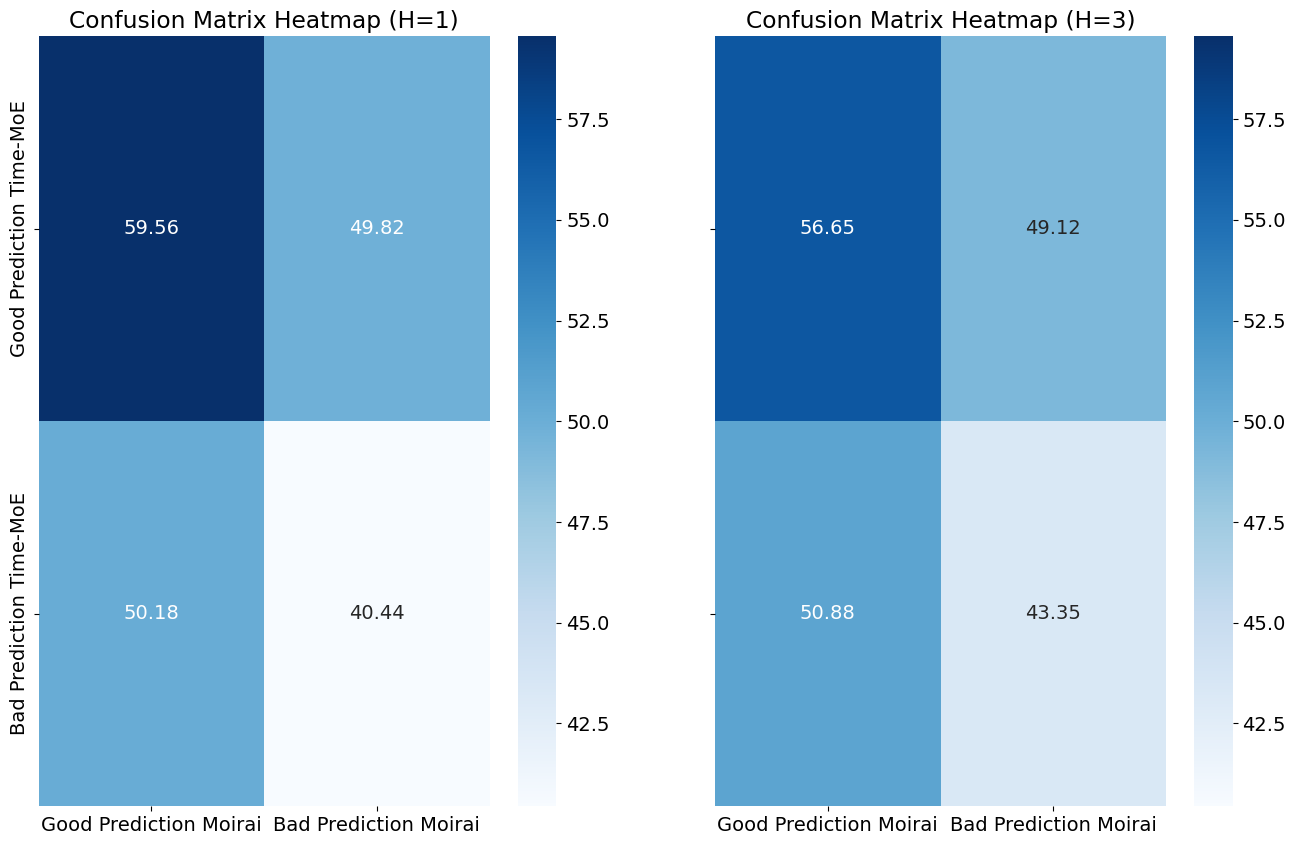

In [72]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import ast

# Ensure the output directory exists
output_dir = "analysis/confusion_matrix/"
os.makedirs(output_dir, exist_ok=True)

# Sample Data Variables
def get_model_metrics(horizon_idx):
    TP_moirai = FP_moirai = TN_moirai = FN_moirai = 0
    TP_time_moe = FP_time_moe = TN_time_moe = FN_time_moe = 0

    # Assume load_model_data() is defined elsewhere
    for model in ["moirai", "time_moe"]:
        df = load_model_data(model)
        first_predicted_row, last_predicted_row = 383, len(df) - 12

        for index, row in df[first_predicted_row:last_predicted_row].iterrows():
            day_index = index.weekday()
            if day_index in days.keys():
                TP_list = ast.literal_eval(row["TP"])
                FP_list = ast.literal_eval(row["FP"])
                TN_list = ast.literal_eval(row["TN"])
                FN_list = ast.literal_eval(row["FN"])

                if model == "moirai":
                    TP_moirai += TP_list[horizon_idx]
                    FP_moirai += FP_list[horizon_idx]
                    TN_moirai += TN_list[horizon_idx]
                    FN_moirai += FN_list[horizon_idx]
                elif model == "time_moe":
                    TP_time_moe += TP_list[horizon_idx]
                    FP_time_moe += FP_list[horizon_idx]
                    TN_time_moe += TN_list[horizon_idx]
                    FN_time_moe += FN_list[horizon_idx]

    total_predictions = TP_moirai + FP_moirai + TN_moirai + FN_moirai + TP_time_moe + FP_time_moe + TN_time_moe + FN_time_moe

    # Confusion Matrix Logic (Updated)
    conf_matrix = np.array([
        [(TP_moirai + TN_moirai + TP_time_moe + TN_time_moe) / total_predictions * 100,
         (TP_time_moe + TN_time_moe + FP_moirai + FN_moirai) / total_predictions * 100],
        [(TP_moirai + TN_moirai + FP_time_moe + FN_time_moe) / total_predictions * 100,
         (FP_moirai + FN_moirai + FP_time_moe + FN_time_moe) / total_predictions * 100]
    ])

    return conf_matrix

# Generate both matrices
conf_matrix_h1 = get_model_metrics(0)  # H=1
conf_matrix_h3 = get_model_metrics(2)  # H=3

# Find common color scale
vmin = min(conf_matrix_h1.min(), conf_matrix_h3.min())
vmax = max(conf_matrix_h1.max(), conf_matrix_h3.max())

# Plotting
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(1, 2, figsize=(16, 10))  # Side-by-side comparison

# Heatmap for H=1
sns.heatmap(conf_matrix_h1, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title("Confusion Matrix Heatmap (H=1)")
axes[0].set_xticks([0.5, 1.5])
axes[0].set_xticklabels(['Good Prediction Moirai', 'Bad Prediction Moirai'])
axes[0].set_yticks([0.5, 1.5])
axes[0].set_yticklabels(['Good Prediction Time-MoE', 'Bad Prediction Time-MoE'])

# Heatmap for H=3
sns.heatmap(conf_matrix_h3, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title("Confusion Matrix Heatmap (H=3)")
axes[1].set_xticks([0.5, 1.5])
axes[1].set_xticklabels(['Good Prediction Moirai', 'Bad Prediction Moirai'])
axes[1].set_yticks([0.5, 1.5])
axes[1].set_yticklabels([])  # Remove redundant y-axis labels for visual clarity

# Save and Compress Combined Image
combined_output_path = os.path.join(output_dir, "Confusion Matrix Moirai Time-Moe.png")
plt.savefig(combined_output_path, dpi=300, bbox_inches='tight')

# Optional Compression (already optimized by default for PNGs)
Image.open(combined_output_path).save(combined_output_path, format="PNG", optimize=True, compress_level=9)

plt.show()

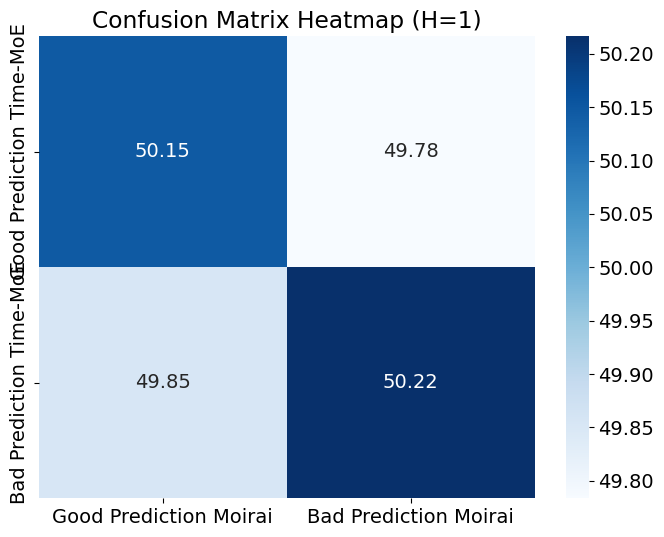

In [64]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Données originales
dataset = np.array([[59.73, 40.27],
                    [59.38, 40.62]])

# Correction des données pour que les lignes et colonnes totalisent 100%
row_totals = dataset.sum(axis=1)
col_totals = dataset.sum(axis=0)

dataset_corrected = np.array([
    [dataset[0, 0] / row_totals[0] * 100, dataset[0, 1] / row_totals[0] * 100],
    [dataset[1, 0] / row_totals[1] * 100, dataset[1, 1] / row_totals[1] * 100]
])

# Ajuster les colonnes également
dataset_final = np.array([
    [dataset_corrected[0, 0] / col_totals[0] * 100, dataset_corrected[0, 1] / col_totals[1] * 100],
    [dataset_corrected[1, 0] / col_totals[0] * 100, dataset_corrected[1, 1] / col_totals[1] * 100]
])

# Affichage de la heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(dataset_final, annot=True, cmap='Blues', cbar=True, fmt=".2f")

# Configurer les axes
tick_labels_x = ["Good Prediction Moirai", "Bad Prediction Moirai"]
tick_labels_y = ["Good Prediction Time-MoE", "Bad Prediction Time-MoE"]

ax.set_xticklabels(tick_labels_x)
ax.set_yticklabels(tick_labels_y)

plt.title("Confusion Matrix Heatmap (H=1)")
plt.show()

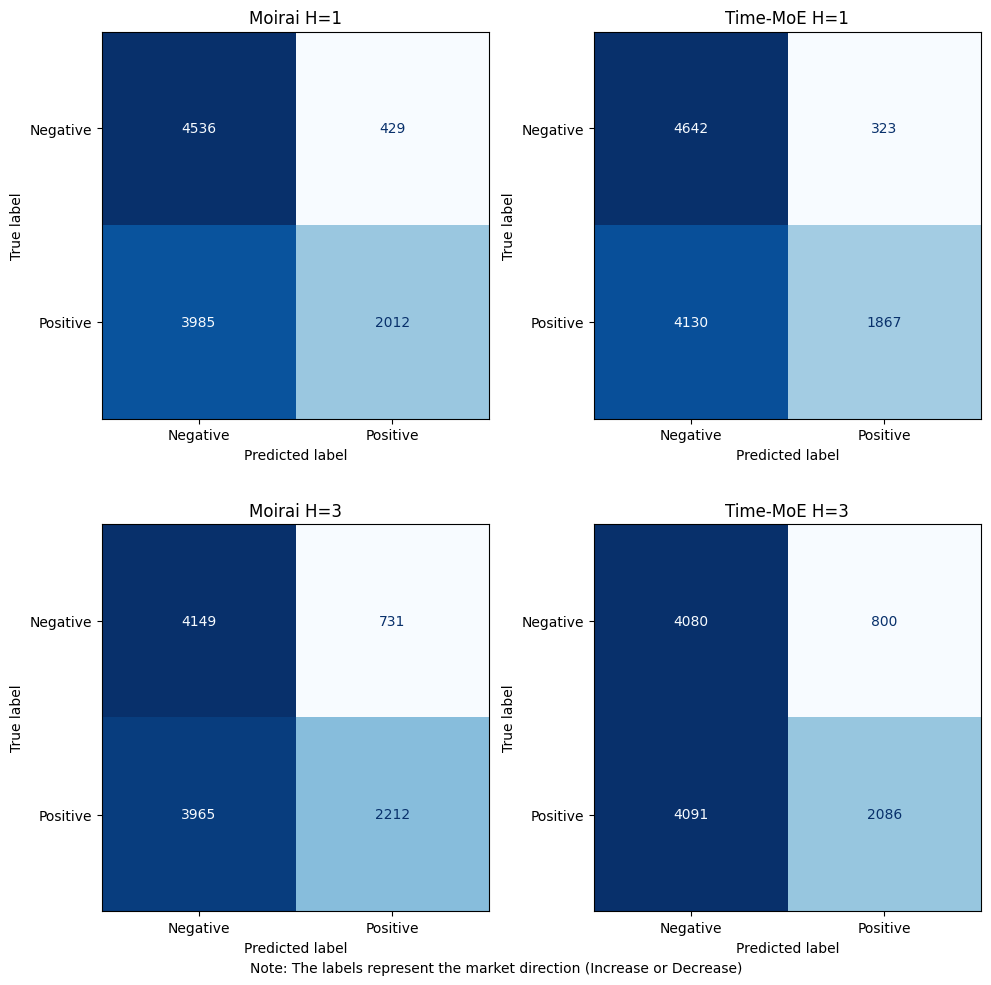

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix data
# Note: The labels represent the market direction (Increase or Decrease)
confusion_data = {
    "Moirai H=1": np.array([[4536, 429], [3985, 2012]]),
    "Time-MoE H=1": np.array([[4642, 323], [4130, 1867]]),
    "Moirai H=3": np.array([[4149, 731], [3965, 2212]]),
    "Time-MoE H=3": np.array([[4080, 800], [4091, 2086]])
}

# Plotting confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, (model, matrix) in zip(axes.flatten(), confusion_data.items()):
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=["Negative", "Positive"])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(model)

plt.tight_layout()

output_path = f"analysis/confusion_matrix/confusion_matrix_moirai_time_moe.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight')

# Overwrite with a compressed version
Image.open(output_path).save(output_path, format="PNG", optimize=True, compress_level=9)

# Add a note on the plot
plt.figtext(0.5, 0.01, 'Note: The labels represent the market direction (Increase or Decrease)', ha='center', fontsize=10)
plt.show()


# Buckets Analysis

### **Model Precision Analysis by Feature Buckets**
This notebook analyzes the precision of three different models (`moirai`, `chronos`, `time_moe`) by quantile buckets of selected features. The results are visualized in precision plots for each feature.

In [ ]:
import ast
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- 1) Load model data (only once) ---
df_moirai = load_model_data("moirai")
df_chronos = load_model_data("chronos")
df_time_moe = load_model_data("time_moe")

# --- 2) Define common parameters ---
first_predicted_row, last_predicted_row = 383, len(df_moirai) - 12
features = ["ATR_10", "RSI", "DistanceToEMM20", "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60", "Volume"]

# For plotting
horizons = [0, 2, 11]  # H=1, H=3, H=12
horizon_labels = ["H=1", "H=3", "H=12"]
horizon_styles = ['-', '--', ':']  # solid, dashed, dotted
model_colors = {"moirai": "blue", "chronos": "red", "time_moe": "green"}
ventile_labels = [f"{i*5}-{(i+1)*5}" for i in range(20)]  # "0-5", "5-10", ..., "95-100"

# --- 3) Loop over each feature ---
for feature in features:
    # --- 3a) Compute the ventiles for this feature (using moirai data) ---
    feature_ventile = df_moirai[feature].quantile([i / 20 for i in range(1, 20)])
    
    # --- 3b) Create the data structure for each model ---
    models = {
        "moirai": {"df": df_moirai, "quantile_data": []},
        "chronos": {"df": df_chronos, "quantile_data": []},
        "time_moe": {"df": df_time_moe, "quantile_data": []}
    }
    
    # --- 3c) Initialize quantile buckets for each model ---
    for model_name, model_data in models.items():
        for i, value in enumerate(feature_ventile):
            model_data["quantile_data"].append({
                'quantile': i + 1,
                'value': value,
                'TP_list': [0] * 12,  # 12 horizons
                'FP_list': [0] * 12
            })
        # Add last bucket for values above the highest ventile
        model_data["quantile_data"].append({
            'quantile': 20,
            'value': float('inf'),
            'TP_list': [0] * 12,
            'FP_list': [0] * 12
        })
    
    # --- 3d) Fill the quantile buckets with TP/FP values for each model ---
    for model_name, model_data in models.items():
        df_model = model_data["df"]
        
        # Iterate over the predicted rows only
        for index, row in df_model[first_predicted_row:last_predicted_row].iterrows():
            feature_value = row[feature]
            TP_list = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            
            # Find which quantile bucket this row's feature_value belongs to
            for q in model_data["quantile_data"]:
                if feature_value <= q['value']:
                    for i in range(12):  # 12 horizons
                        q['TP_list'][i] += TP_list[i]
                        q['FP_list'][i] += FP_list[i]
                    break  # Stop after assigning to the first matching bucket
    
    # --- 3e) Plot precision by quantile bucket for each model and horizon ---
    plt.figure(figsize=(12, 6))
    
    for model_name, model_data in models.items():
        for h_idx, horizon in enumerate(horizons):
            precision_values = []
            for q in model_data["quantile_data"]:
                TP = q['TP_list'][horizon]
                FP = q['FP_list'][horizon]
                precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                precision_values.append(precision)
            
            # Plot precision values
            plt.plot(
                range(len(precision_values)),
                precision_values,
                color=model_colors[model_name],
                linestyle=horizon_styles[h_idx],
                label=f"{model_name} {horizon_labels[h_idx]}"
            )
    
    # Add horizontal lines for reference (optional)
    plt.axhline(y=0.7, color='black', linestyle='--', alpha=0.7, label='Precision = 0.7')
    plt.axhline(y=0.8, color='black', linestyle='--', alpha=0.7, label='Precision = 0.8')
    
    # Set x-axis labels to ventile ranges
    plt.xticks(range(20), ventile_labels, rotation=45)
    plt.ylim(0.4, 1)
    
    plot_title = f"ES Future - Precision per Buckets for {feature}"
    plt.xlabel('Feature Ventiles (%)')
    plt.ylabel('Precision')
    plt.title(plot_title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best')
    plt.tight_layout()

    file_path = f"analysis/bucket_analysis_plots/temporary_buckets/{plot_title}.png"
    plt.savefig(file_path, dpi=300, bbox_inches="tight")
    Image.open(file_path).save(file_path, format="PNG", optimize=True, compress_level=9)
    
    # Show the plot for the current feature
    plt.show()

### Bucket analysis for H=1, for the three Models and for all features

The code is very similar with the one above. For clarity, the two codes are separated because the first one plot 7 graphs (one for each feature) with all three models on it. While this part focuses on plotting 3 graphs (one for each models) by fixing H=1 and the model. The two logics are different and need two separate code.

In [ ]:
import ast
import matplotlib.pyplot as plt
import numpy as np

# 1) Load the data for all models
df_moirai = load_model_data("moirai")
df_chronos = load_model_data("chronos")
df_time_moe = load_model_data("time_moe")

# 2) Define parameters
first_predicted_row, last_predicted_row = 383, len(df_moirai) - 12
features = ["ATR_10", "RSI", "Volume", "DistanceToEMM20", 
            "DistanceToEMM60", "DistanceToMM20", "DistanceToMM60"]

# We'll focus on H=1, which is index 0 in TP_list/FP_list
horizon_index = 0

# Keep a dictionary of model names to their DataFrame
models = {
    "moirai": df_moirai,
    "chronos": df_chronos,
    "time_moe": df_time_moe
}

# Each feature will get its own color
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# For labeling x-axis with ventiles
ventile_labels = [f"{i*5}-{(i+1)*5}" for i in range(20)]

# 3) Create one figure per model
for model_name, df_model in models.items():
    
    # Start a new figure for this model
    plt.figure(figsize=(12, 6))
    
    # For each feature, we will compute ventiles (using moirai's data, 
    # as in your advanced code) and plot on this model's figure
    for f_idx, feature in enumerate(features):
        
        # --- a) Compute ventiles for this feature (based on df_moirai) ---
        feature_ventiles = df_moirai[feature].quantile([i / 20 for i in range(1, 20)])
        
        # --- b) Initialize the quantile buckets (20 buckets) ---
        quantile_data = []
        for q_val in feature_ventiles:
            quantile_data.append({'value': q_val, 'TP': 0, 'FP': 0})
        # One extra bucket for values above the 95th percentile
        quantile_data.append({'value': float('inf'), 'TP': 0, 'FP': 0})
        
        # --- c) Fill each bucket with TP/FP for horizon=1 ---
        #     using the current model's DataFrame
        for index, row in df_model[first_predicted_row:last_predicted_row].iterrows():
            feature_value = row[feature]
            
            # Convert the "TP" and "FP" column from string to list
            TP_list = ast.literal_eval(row["TP"])
            FP_list = ast.literal_eval(row["FP"])
            
            # Find the correct bucket for this feature_value
            for bucket in quantile_data:
                if feature_value <= bucket['value']:
                    bucket['TP'] += TP_list[horizon_index]  # H=1
                    bucket['FP'] += FP_list[horizon_index]  # H=1
                    break
        
        # --- d) Compute precision for each bucket ---
        precision_values = []
        for bucket in quantile_data:
            tp = bucket['TP']
            fp = bucket['FP']
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            precision_values.append(precision)
        
        # --- e) Plot the precision curve for this feature on this model ---
        color = colors[f_idx]
        label = f"{feature} (H=1)"
        
        plt.plot(
            range(20),             # x-values: bucket indices 0..19
            precision_values,      # y-values: computed precision
            color=color,
            label=label
        )
    
    # 4) Finalize the plot for this model
    plt.axhline(y=0.7, color='black', linestyle='--', alpha=0.7, label='Precision = 0.7')
    plt.axhline(y=0.8, color='black', linestyle='--', alpha=0.7, label='Precision = 0.8')
    
    plt.xticks(range(20), ventile_labels, rotation=45)
    plt.ylim(0.4, 1)
    plt.xlabel('Feature Ventiles (%)')
    plt.ylabel('Precision')
    plt.title(f"Precision per Buckets (H=1) for {model_name.capitalize()}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(loc='best', ncol=2)
    plt.tight_layout()
    

    file_path = f"../bucket_analysis_plots/temporary_buckets/{model_name}_H1_Precision_Buckets_AllFeatures.png"
    plt.savefig(file_path, dpi=300, bbox_inches="tight")
    Image.open(file_path).save(file_path, format="PNG", optimize=True, compress_level=9)
    
    # Show the figure for the current model
    plt.show()


# Scatter plot DistanceToEMA20, DistanceToEMA60

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load the historical data
df = pd.read_csv("data/ES=F.csv", parse_dates=True, index_col=0)

# Compute Pearson and Spearman correlation
pearson_corr = df[['DistanceToEMM20', 'DistanceToEMM60']].corr(method='pearson')
spearman_corr = df[['DistanceToEMM20', 'DistanceToEMM60']].corr(method='spearman')

print("Pearson Correlation:\n", pearson_corr)
print("Spearman Correlation:\n", spearman_corr)

# Density Plot
plt.figure(figsize=(14, 10))
sns.kdeplot(data=df, x='DistanceToEMM20', y='DistanceToEMM60', fill=True, cmap="Blues", levels=50)

# Adding correlation coefficients as text
plt.text(0.05, 0.95, f"Pearson: {pearson_corr.iloc[0, 1]:.2f}\nSpearman: {spearman_corr.iloc[0, 1]:.2f}",
         fontsize=12, transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))

title = "Density Plot DistanceToEMA20 vs. DistanceToEMA60"
plt.title(title)

out_file = f"analysis/density_plot/temporary_density_plot/{title}.png"
plt.savefig(out_file, dpi=300, bbox_inches='tight')
Image.open(out_file).save(out_file, format="PNG", optimize=True, compress_level=9)

plt.show()